# Oscillatory Shear Test - April 14th 2022

In [1]:
import numpy as np

import matplotlib.pyplot as plt

from monk import nb

from typing import Callable, Optional

import hoomd
import gsd.hoomd

from monk import prep
from monk import pair

import ex_render

In [14]:
seed = 124
device = hoomd.device.auto_select()
sim = hoomd.Simulation(device, seed=seed)

N = 512
rng = prep.init_rng(seed + 1)
snap = prep.approx_euclidean_snapshot(N, 25, rng, ratios=[50,50], diams=[1.0, 1.4])

sim.create_state_from_snapshot(snap)
sim.state.thermalize_particle_momenta(hoomd.filter.All(), 0.01)
# sim.always_compute_pressure = True

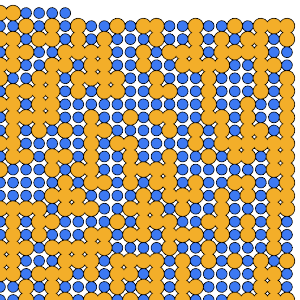

In [15]:
ex_render.render_disk_frame(frame=sim.state.get_snapshot())

In [16]:
integrator = hoomd.md.Integrator(dt=0.001)

nlist = hoomd.md.nlist.Tree(0.3)
hertz = pair.bi_hertz(nlist)
nve = hoomd.md.methods.NVE(hoomd.filter.All())
integrator.forces = [hertz]
integrator.methods = [nve]

sim.operations.integrator = integrator

In [17]:
sim.run(0)

In [18]:
sim.run(10_000)

In [42]:
sim.state.get_snapshot().particles.position

array([[-9.61475583, 10.10822456,  0.        ],
       [10.02748451, 10.27889362,  0.        ],
       [-8.02242152, -9.88830497,  0.        ],
       ...,
       [-6.63278977,  7.29498905,  0.        ],
       [-6.6986235 ,  8.2304819 ,  0.        ],
       [-4.90597029,  8.62947429,  0.        ]])

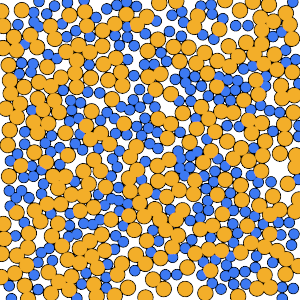

In [21]:
ex_render.render_disk_frame(frame=sim.state.get_snapshot())

In [44]:
variant = hoomd.variant.Ramp(0, 1, sim.timestep, t_ramp=10_000)

initial_box = sim.state.box
final_box = hoomd.Box.from_box(initial_box)  # make a copy of initial_box
final_rho = 1.4
final_box.volume = sim.state.N_particles / final_rho

resize_box = hoomd.update.BoxResize(hoomd.trigger.Periodic(10), sim.state.box, final_box, variant)

sim.operations.updaters.clear()
sim.operations.updaters.append(resize_box)

In [53]:
sim.state.box

hoomd.box.Box(Lx=19.123657749350297, Ly=19.123657749350297, Lz=0.0, xy=0.0, xz=0.0, yz=0.0)

In [46]:
sim.run(10_000)

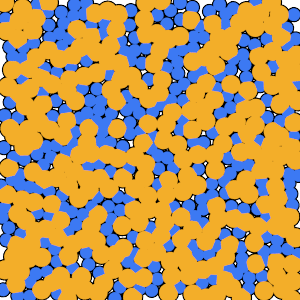

In [47]:
ex_render.render_disk_frame(frame=sim.state.get_snapshot())

In [49]:
integrator.forces.pop()

In [50]:
fire = hoomd.md.minimize.FIRE(dt=0.05,
                        force_tol=1e-2,
                        angmom_tol=1e-2,
                        energy_tol=1e-7)
fire.methods.append(hoomd.md.methods.NVE(hoomd.filter.All()))
fire.forces = [hertz]
sim.operations.integrator = fire

In [51]:
sim.run(1_000)

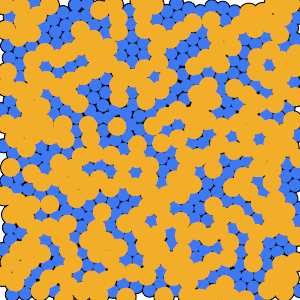

In [52]:
ex_render.render_disk_frame(frame=sim.state.get_snapshot())